# K-Nearest Neighborhood Algorithm 직접 코딩
### Object Oriented Programming

In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## KNN class 생성

In [2]:
class KNN_classify:
    def __init__(self, X, y, y_names):
        self.X = X
        self.y = y
        self.y_names = y_names
        print('KNN_classify 객체를 생성했습니다.')     
        
    def predict(self, X_test, k=3, weight=False): # KNN 예측치 반환하는 함수
        if type(X_test) != type(self.X): # ndarray가 아니면
            try: X_test = np.array(X_test)
            except: raise Exception('test set must be iterable and can be tranformed as ndarray')
        
        if len(X_test.shape) <= 1: # X_test가 스칼라 또는 1차원 경우
            try: X_test = X_test.reshape(1, X_test.shape[0]) # 2차원으로 변경
            except: raise Exception('test set must not be scalar')
            
        if X_test.shape[1] != self.X.shape[1]: # train과 test의 column 수가 다른 경우
            raise Exception('The number of columns is different between X_train and X_test')
        
        pred_res = []
        for xt in X_test:            
            dist = np.sqrt(((self.X-xt)**2).sum(axis=1)) # 거리 계산
            k_index = dist.argsort()[1:k+1] # 본인 제외 거리가 가장 가까운 k개의 인덱스
            
            if weight: 
                weights = 1/dist[k_index]
                res = KNN_classify.__weighted(self, weights, self.y[k_index])
            else: res = KNN_classify.__mode(self, self.y[k_index]) # k개 중 가장 많은 label
            
            pred_res.append(res)
        
        pred_res = np.array(pred_res)

        return pred_res
    
    def __predict_cv(self, X_train, y_train, X_test, k, weight=False): # CV 과정에서 KNN 예측치 반환하는 함수
        if type(X_test) != type(self.X): # ndarray가 아니면
            try: X_test = np.array(X_test)
            except: raise Exception('test set must be iterable and can be tranformed as ndarray')
        
        if len(X_test.shape) <= 1: # X_test가 스칼라 또는 1차원 경우
            try: X_test = X_test.reshape(1, X_test.shape[0]) # 2차원으로 변경
            except: raise Exception('test set must not be scalar')
            
        if X_test.shape[1] != X_train.shape[1]: # train과 test의 column 수가 다른 경우
            raise Exception('The number of columns is different between X_train and X_test')
        
        pred_res = []
        for xt in X_test:
            dist = np.sqrt(((X_train-xt)**2).sum(axis=1)) # 거리 계산
            k_index = dist.argsort()[:k] # 거리가 가장 가까운 k개의 인덱스
            
            if weight: 
                weights = 1/dist[k_index]
                res = KNN_classify.__weighted(self, weights, y_train[k_index]) # k개 중 weight가 가장 높은 label
            else: res = KNN_classify.__mode(self, y_train[k_index]) # k개 중 가장 많은 label
            
            pred_res.append(res)
        
        pred_res = np.array(pred_res)

        return pred_res

    def accuracy(self, res, y_test): # KNN 예측결과 정답률 계산
        return round(len(res[res == y_test]) / len(res), 4)
    
    def __mode(self, arr): # 최빈값을 구하는 함수
        d = dict()
        for key in set(arr):
            d.setdefault(key, 0)
        for x in arr:
            d[x] += 1

        res = sorted(list(d.items()), key=lambda x: x[1], reverse=True)[0][0]

        return res
    
    def __weighted(self, weights, arr):
        d = dict()
        for key in set(arr):
            d.setdefault(key, 0)
        for x in range(len(arr)):
            d[arr[x]] += weights[x]
        res = sorted(list(d.items()), key=lambda x: x[1], reverse=True)[0][0]
        
        return res
    
    def CV(self, cv=10, k_min=1, k_max=100, weight=False):
        time.sleep(0.5)
        self.cv = cv
        np.random.seed(970205)
        self.shuffled = np.arange(0,len(self.X)) # 입력 랜덤 셔플링을 위한 인덱스
        np.random.shuffle(self.shuffled)
        X_s = self.X[self.shuffled]
        y_s = self.y[self.shuffled]

        if k_min < 1: 
            print('k_min must be 1 or bigger. Replace prior k_min with 1')
            k_min = 1
        if k_max < k_min:
            raise Exception('k_max must be bigger than k_min')

        t = len(X_s)//cv # test set의 원소 개수
        self.cv_acc = pd.DataFrame(columns=['accuracy'])
        
        for k in tqdm(range(k_min, k_max)):
            acc_sum = 0
            for c in range(1, cv+1):
                X_test = X_s[(c-1)*t:c*t]
                y_test = y_s[(c-1)*t:c*t]

                X_train = np.concatenate([X_s[0:(c-1)*t], X_s[c*t:len(X_s)]])
                y_train = np.concatenate([y_s[0:(c-1)*t], y_s[c*t:len(X_s)]])
                
                res = KNN_classify.__predict_cv(self, X_train, y_train, X_test, k, weight=weight)
                acc = KNN_classify.accuracy(self, res, y_test)
                acc_sum += acc
                
            self.cv_acc.loc[k] = acc_sum/cv
        
        self.optimal_k = self.cv_acc.idxmax()[0]
        self.optimal_accuracy = round(self.cv_acc.max()[0], 4)
        
        return self.cv_acc

In [3]:
def scale(arr, center=True, standard=True): # 정규화 함수
    arr = np.array(arr)
    if standard: return (arr-arr.mean(axis=0))/arr.std(axis=0)
    elif center: return arr-arr.mean(axis=0)
    else: return arr

# cancer data

In [4]:
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
X = scale(X)
y = scale(y)
y_names = cancer.target_names

### no weight

In [5]:
c = KNN_classify(X, y, y_names)
c.CV()

KNN_classify 객체를 생성했습니다.


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:09<00:00, 10.71it/s]


,accuracy
1,0.94284
2,0.95534
3,0.96606
4,0.96607
5,0.97141
...,...
95,0.93750
96,0.93393
97,0.93571
98,0.93215


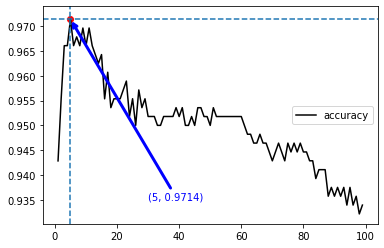

In [6]:
c.cv_acc.plot(color='black')
plt.scatter(c.optimal_k, c.optimal_accuracy, color='red')

plt.axhline(c.optimal_accuracy, ls='--')
plt.axvline(c.optimal_k, ls='--')

plt.annotate(f'({c.optimal_k}, {c.optimal_accuracy})', xy=(c.optimal_k, c.optimal_accuracy),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='blue'), xytext=(30,0.935), color='blue')

plt.show()

In [7]:
predict = c.predict(X, k=5)
print(f'accuracy: {c.accuracy(predict, y)}')

accuracy: 0.9701


### weight

In [8]:
c = KNN_classify(X, y, y_names)
c.CV(weight=True)

KNN_classify 객체를 생성했습니다.


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:10<00:00,  9.58it/s]


,accuracy
1,0.94284
2,0.94284
3,0.96606
4,0.96784
5,0.97141
...,...
95,0.94107
96,0.94285
97,0.94285
98,0.93929


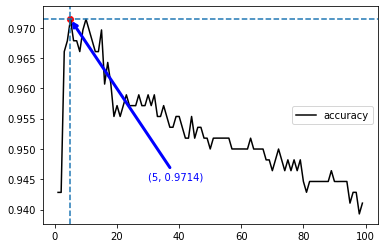

In [9]:
c.cv_acc.plot(color='black')
plt.scatter(c.optimal_k, c.optimal_accuracy, color='red')

plt.axhline(c.optimal_accuracy, ls='--')
plt.axvline(c.optimal_k, ls='--')

plt.annotate(f'({c.optimal_k}, {c.optimal_accuracy})', xy=(c.optimal_k, c.optimal_accuracy),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='blue'), xytext=(30,0.945), color='blue')

plt.show()

In [10]:
predict = c.predict(X, k=5, weight=True)
print(f'accuracy: {c.accuracy(predict, y)}')

accuracy: 0.9701


# iris data

In [11]:
iris = datasets.load_iris()

X = iris.data
y = iris.target
X = scale(X)
y = scale(y)

x_names = iris.feature_names
y_names = iris.target_names

### no weight

In [12]:
a = KNN_classify(X, y, y_names)
a.predict(X)
a.CV(k_max=101)

KNN_classify 객체를 생성했습니다.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.32it/s]


,accuracy
1,0.93333
2,0.92666
3,0.93333
4,0.92666
5,0.92666
...,...
96,0.70666
97,0.70000
98,0.70000
99,0.70000


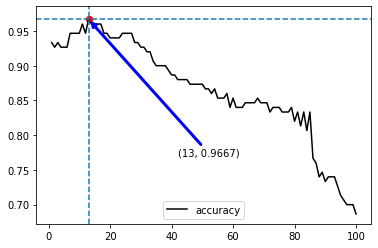

In [13]:
a.cv_acc.plot(color='k')

plt.axhline(a.optimal_accuracy, ls='--')
plt.axvline(a.optimal_k, ls='--')

plt.scatter(a.optimal_k, a.optimal_accuracy, color='red', s=40)

plt.annotate(f'({a.optimal_k}, {round(a.optimal_accuracy, 4)})', xy=(a.optimal_k, a.optimal_accuracy), xytext=(42,0.77),
            arrowprops=dict(arrowstyle='->', color='blue', linewidth=3))


plt.show()

In [14]:
predict = a.predict(X, k=13)
print(f'accuracy: {a.accuracy(predict, y)}')

accuracy: 0.9667


### weight

In [15]:
a = KNN_classify(X, y, y_names)
a.CV(k_max=101, weight=True)

KNN_classify 객체를 생성했습니다.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.46it/s]


,accuracy
1,0.93333
2,0.93333
3,0.93333
4,0.93999
5,0.92666
...,...
96,0.93333
97,0.93333
98,0.93333
99,0.93333


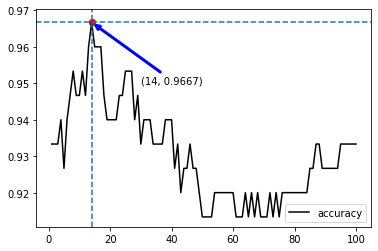

In [16]:
a.cv_acc.plot(color='k')

plt.axhline(a.optimal_accuracy, ls='--')
plt.axvline(a.optimal_k, ls='--')

plt.scatter(a.optimal_k, a.optimal_accuracy, color='red', s=40)

plt.annotate(f'({a.optimal_k}, {round(a.optimal_accuracy, 4)})', xy=(a.optimal_k, a.optimal_accuracy), xytext=(30,0.95),
            arrowprops=dict(arrowstyle='->', color='blue', linewidth=3))


plt.show()

In [17]:
predict = a.predict(X, k=14)
print(f'accuracy: {a.accuracy(predict, y)}')

accuracy: 0.9667
